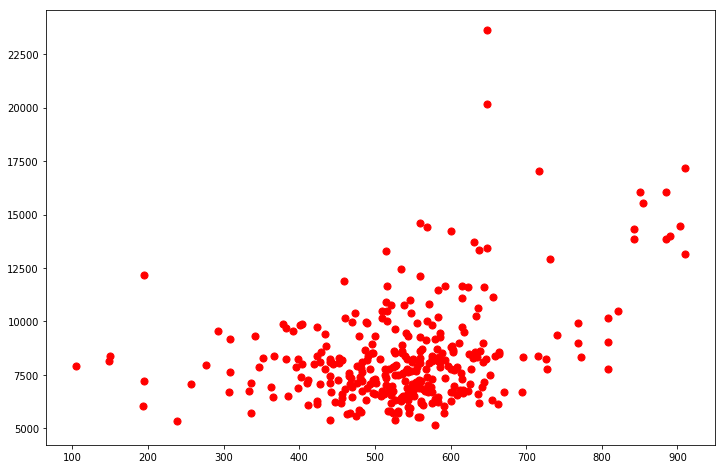

centroid_points [2744. 3458. 2314. 3649. 3867. 2192. 2728. 2797. 2255.]
Found due to 0 minimum changes
Found after 2 iterations
centroid_points [ 6611.  6929.  4382.  6915. 11290.  5525.  6806.  6922.  6922.]
Found due to 8 minimum changes
Found after 2 iterations
centroid_points [3458. 2728. 2255. 4638. 3857. 1962. 4037. 2725. 2564.]
centroid_points [2744. 3458. 3649. 3867. 2797. 2804. 4638. 3857. 4037.]
centroid_points [3458. 3649. 3867. 4638. 3857. 4037. 4468. 3569. 3309.]
centroid_points [3458. 3649. 3867. 4638. 3857. 4037. 4468. 3569. 3309.]
Found due to 0 minimum changes
Found after 5 iterations
centroid_points [0. 0. 0. 0. 0. 0. 0. 0. 0.]
Found due to 2 minimum changes
Found after 2 iterations
centroid_points [2744. 2314. 2192. 2728. 2797. 2255. 2804. 1962. 2070.]
centroid_points [2744. 3458. 2314. 3649. 2192. 2728. 2797. 2255. 2804.]
centroid_points [2744. 2314. 2192. 2728. 2797. 2255. 2804. 1962. 2070.]
centroid_points [2744. 2314. 2192. 2728. 2797. 2255. 2804. 1962. 2070.]
Fo

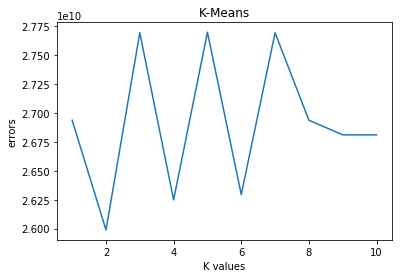

K = 1)
SSE = 26935559379.0)
K = 2)
SSE = 25989074517.0)
K = 3)
SSE = 27690089453.0)
K = 4)
SSE = 26248580087.0)
K = 5)
SSE = 27694669997.0)
K = 6)
SSE = 26293932819.0)
K = 7)
SSE = 27690089453.0)
K = 8)
SSE = 26935559379.0)
K = 9)
SSE = 26809258715.0)
K = 10)
SSE = 26809258715.0)


In [88]:
import numpy as np
import matplotlib.pyplot as plt
import math
from pandas import read_table
import random

def download_data(fileLocation, fields=None):
    '''
    Downloads the data for this script into a pandas DataFrame. Uses columns indices provided
    '''

    frame = read_table(
        fileLocation,
        
        # Specify the file encoding
        # Latin-1 is common for data from US sources
        encoding='latin-1',
        #encoding='utf-8',  # UTF-8 is also common

        # Specify the separator in the data
        sep=',',            # comma separated values

        # Ignore spaces after the separator
        skipinitialspace=True,

        # Generate row labels from each row number
        index_col=None,

        # Generate column headers row from each column number
        header=None,          # no header  #0 =>  use the first line as headers

        usecols=fields
    )

    # Return the entire frame
    return frame 

MAX_ITERATIONS = 50
MIN_SAMPLE_CHANGE = 10


colors=['red', 'blue', 'black', 'brown', 'c', 'm', 'y', 'k', 'w', 'orange']


def run_kmeans_clustering(k_value=2, showPlots=False, data=None):
    """  Calculate K means, given K  """
    # pick "samples" random x,y coordinates from 0 to "samples"

    # number of columns of data
    samples_size = len(data)
    data_dimensions = len(data[0])
    xy_samples = data
    

    # make sure not to show plots if more than 2 dimensions
    if data_dimensions != 2:
        showPlots = False

    if showPlots:
        plt.scatter(xy_samples[:, 0], xy_samples[:, 1], c='g')
        plt.title("Data Points")
        plt.show()

    def indexes_to_list_array(indexes):
        """  convert from indexes to an array of the x-y coordinates at each index   """
        items = []
        for index in indexes:
            items.append(xy_samples[index, :])
        return np.array(items)
    # initialize dictionary
    grouped_coordinates_indexes = initialize_dict(k_value)
    
    current_iteration = 0
    # main iterations
    while(current_iteration < MAX_ITERATIONS):

        if current_iteration == 0:
            #  pick 2 random sets of x,y coordinates to be centroids to start off
            centroid_points = np.random.randint(samples_size, size=(k_value, data_dimensions))
            if showPlots:
                for i in range(k_value):
                    plt.scatter(centroid_points[i, 0], centroid_points[i, 1], c=colors[i], marker='x')
                plt.scatter(xy_samples[:, 0], xy_samples[:, 1], c='g')
                plt.title("Initial centroids")
                plt.show()
        else:
            #find centroids based on the current memberships
            centroid_points = _get_centroids(data_dimensions, xy_samples, grouped_coordinates_indexes)
            if showPlots:
                _display_plot("Calculate centroids", centroid_points, xy_samples, grouped_coordinates_indexes)


        #  with new centroids, calculate distances and assign points to new groups
        new_grouped_coordinates_indexes = assign_points_to_groups(k_value, xy_samples, centroid_points)


        if showPlots:
            _display_plot("Assign points to two centroids", centroid_points, xy_samples, new_grouped_coordinates_indexes)
        
        max_changed = check_minimum_changes_met(k_value, current_iteration, grouped_coordinates_indexes, new_grouped_coordinates_indexes)
        if max_changed >= 0:
            # already shown, but show if "showPlots" if false
            if data_dimensions == 2 and not showPlots: 
                _display_plot("Assign points to two centroids", centroid_points, xy_samples, new_grouped_coordinates_indexes)

            print("Found due to {} minimum changes".format(max_changed))
            break;
        
        # reassign new index group to existing
        grouped_coordinates_indexes = new_grouped_coordinates_indexes.copy()
        
        current_iteration += 1

    print("Found after {} iterations".format(current_iteration + 1))
    result_arrays = []
    for i in range(k_value):
        # return list of list of <centroid, grouped points>
        result_arrays.append([centroid_points[i], indexes_to_list_array(grouped_coordinates_indexes[i])])

    return result_arrays


def initialize_dict(k_value):
    dict={}
    for i in range(k_value):
        dict[i] = []
    return dict

def assign_points_to_groups(k_value, xy_samples, centroid_points):
    """
    assign each sample to the centroid it is closest to
    returns:
        dictionary of centroid (index) mapped to grouping of samples (indexes) that are closest
    """
    grouped_sample_indexes = initialize_dict(k_value)

    for index in range(len(xy_samples)):
        current_xy_samples = xy_samples[index, :]
        distances_to_centroid = []
        # calculate distance of x/y coordinate from center
        for centroid_index in range(len(centroid_points)):
            distances_to_centroid.append(calc_euclidean_dist_vector(centroid_points[centroid_index, :], current_xy_samples))
        
        minimum_index = distances_to_centroid.index(min(distances_to_centroid))
        grouped_sample_indexes[minimum_index].append(index)
    return grouped_sample_indexes


def calc_euclidean_dist_vector(vector1, vector2):
    #http://www.codehamster.com/2015/03/09/different-ways-to-calculate-the-euclidean-distance-in-python/
    ##################placeholder # stanrt ####################
    dist = [(a - b)**2 for a, b in zip(vector1, vector2)]
    dist = math.sqrt(sum(dist))
    result = dist
    ##################placeholder # end ####################
    return result

def check_minimum_changes_met(k_value, current_iteration, old_grouped_samples, new_grouped_samples):
    if current_iteration > 0:
        # check to see if points within groups changed or not
        unchanged_coordinates = []
        for i in range(k_value):
            original_group_length = len(old_grouped_samples[i])
            unchanged_group_coordinates = set(new_grouped_samples[i]).intersection(old_grouped_samples[i])
            unchanged_coordinates.append(abs(original_group_length - len(unchanged_group_coordinates)))
        # find array that has the most number of samples that have changed
        max_changed_index = unchanged_coordinates.index(max(unchanged_coordinates))
        max_changed = unchanged_coordinates[max_changed_index]
        if max_changed <= MIN_SAMPLE_CHANGE:
            return max_changed
    return -1

def _get_centroids(dimensions, xy_coordinates, groups):
    xy_centroids = []
    for i in range(len(groups)):
        xy_centroids.append(xy_coordinates[groups[i], :])
    centroid_points = get_centroids(dimensions, xy_centroids)
    return centroid_points

def get_centroids(dimensions, xy_groups):#def init_centroids
    #http://www.johnwittenauer.net/machine-learning-exercises-in-python-part-7/
    """ Takes tuple of coordinates
        returns:
            2,2 array of centroid points
    """
    def get_point_mean(array_values):
        """ take care of issue of empty list
        """
        if len(array_values) == 0:
            return 0
        return int(array_values.mean())
    length = len(xy_groups)
    centroid_points = np.zeros((length, dimensions))
    '''print('centroid_points',centroid_points)
    print('dimensions',dimensions)
    print('xy_groups',xy_groups)
    print('length',length)'''
    #  for each group, get the average point
    ##################placeholder # start ####################
    for i in range(length):
        centroid_points[i, :] = get_point_mean(xy_groups[i])
        ##centroid_points[i,j]=get_point_mean(xy_groups[i])
        for j in range (len(xy_groups[i])):#using the first 9 mean of xy_groups
            if j > 8:
                break;
            centroid_points[i, j] = get_point_mean(xy_groups[i][j])
        '''for j in range(dimensions):#random centroid points
            if centroid_points[i][0] == 0:
                centroid_points[i, j] = random.randint(1,3000)#randomly picked 3000
            else:
                centroid_points[i, j] = random.randint(1,int(centroid_points[i][0] ))'''
    print('centroid_points',centroid_points[i, :] )
    ##################placeholder # end ####################   
    return centroid_points

def _display_plot(title, centroid_points, xy_coordinate_samples, grouped_coordinate_sample_indexes):
    for i in range(len(centroid_points)):
        plt.scatter(centroid_points[i, 0], centroid_points[i, 1], c=colors[i], marker='x')
        plt.scatter(xy_coordinate_samples[grouped_coordinate_sample_indexes[i], 0], xy_coordinate_samples[grouped_coordinate_sample_indexes[i], 1], c=colors[i])
    plt.title(title)
    plt.show()


def get_sum_of_squares(dimensions, center, samples):
    """  Get the sum of squared error, given centroid and all of its grouped points  """
    ##################placeholder # start ####################
    '''print('dimensions',dimensions)
    print('center',center)#same number
    print('samples',samples[0])
    print('leng',len(samples))'''
    sse_array =  []
    for k in range(len(samples)):
        total=0
        total=samples[k]-center
        total = total **2
        ##total=sum(samples[k]-center)
        ##sse_array.append((total))
        sse_array.append(sum(total))
    #print('sse_array',sse_array[0])
    sse = sum(sse_array)
    ##sse = sse ** 2
    #print('sse ',sse)
    ##################placeholder # end ####################
    return sse

if __name__ == "__main__":
#  load data    
    data = download_data("cities_life_ratings.csv").values
    #print(data)#[[ 521 6200  237 ...  996 1405 7633]
    
    #to print data
    X = data
    fig, ax = plt.subplots(figsize=(12,8))  
    ax.scatter(X[:, 0], X[:, 1], s=MAX_ITERATIONS, color=colors[0], label='Cluster 1')
    plt.show()
    
    dimensions = len(data[0])
#  evaluating Ks
    ##k_values = [3, 6, 8, 10] # if go higher than 10, need to add to "colors" list
    k_values=[x for x in range(1,11)]
    #random.shuffle(k_values)
    k_errors = []
    for k in k_values:
        result_arrays = run_kmeans_clustering(k, showPlots=True, data=data)
        # step 6: calculate the sum of squared errors (SSE) 
        sse_total = 0
        for i in range(k):
            center = result_arrays[i][0]
            samples = result_arrays[i][1]
            sse_total += get_sum_of_squares(dimensions, center, samples)
        k_errors += [sse_total]
    plt.plot(k_values, k_errors)
    plt.title("K-Means")
    plt.xlabel("K values")
    plt.ylabel("errors")
    plt.show()
    for i in range(len(k_values)):
        print("K = {})".format(k_values[i]))
        print("SSE = {})".format(k_errors[i]))

Found due to 0 minimum changes
Found after 2 iterations
Found due to 0 minimum changes
Found after 11 iterations
Found due to 0 minimum changes
Found after 11 iterations
Found due to 0 minimum changes
Found after 3 iterations
Found due to 0 minimum changes
Found after 2 iterations
Found due to 0 minimum changes
Found after 12 iterations
Found due to 0 minimum changes
Found after 9 iterations
Found due to 0 minimum changes
Found after 18 iterations
Found due to 0 minimum changes
Found after 12 iterations
Found due to 0 minimum changes
Found after 2 iterations


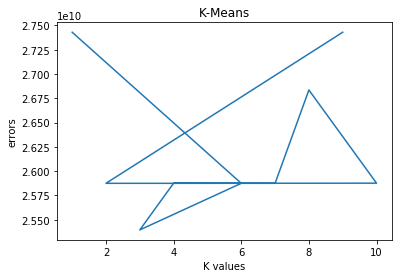

K = 9)
SSE = 27429828940.0)
K = 2)
SSE = 25874719561.0)
K = 5)
SSE = 25874719561.0)
K = 10)
SSE = 25876286977.0)
K = 8)
SSE = 26835331865.0)
K = 7)
SSE = 25874719561.0)
K = 4)
SSE = 25876286977.0)
K = 3)
SSE = 25395072831.0)
K = 6)
SSE = 25874719561.0)
K = 1)
SSE = 27429828940.0)


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import math
from pandas import read_table

def download_data(fileLocation, fields=None):
    '''
    Downloads the data for this script into a pandas DataFrame. Uses columns indices provided
    '''

    frame = read_table(
        fileLocation,
        
        # Specify the file encoding
        # Latin-1 is common for data from US sources
        encoding='latin-1',
        #encoding='utf-8',  # UTF-8 is also common

        # Specify the separator in the data
        sep=',',            # comma separated values

        # Ignore spaces after the separator
        skipinitialspace=True,

        # Generate row labels from each row number
        index_col=None,

        # Generate column headers row from each column number
        header=None,          # no header  #0 =>  use the first line as headers

        usecols=fields
    )

    # Return the entire frame
    return frame 

MAX_ITERATIONS = 50;
MIN_SAMPLE_CHANGE = 0


colors=['red', 'blue', 'black', 'brown', 'c', 'm', 'y', 'k', 'w', 'orange']


def run_kmeans_clustering(k_value=2, showPlots=False, data=None):
    """  Calculate K means, given K  """
    # pick "samples" random x,y coordinates from 0 to "samples"

    # number of columns of data
    samples_size = len(data)
    data_dimensions = len(data[0])
    xy_samples = data
    

    # make sure not to show plots if more than 2 dimensions
    if data_dimensions != 2:
        showPlots = False

    if showPlots:
        plt.scatter(xy_samples[:, 0], xy_samples[:, 1], c='g')
        plt.title("Data Points")
        plt.show()

    def indexes_to_list_array(indexes):
        """  convert from indexes to an array of the x-y coordinates at each index   """
        items = []
        for index in indexes:
            items.append(xy_samples[index, :])
        return np.array(items)
    # initialize dictionary
    grouped_coordinates_indexes = initialize_dict(k_value)
    
    current_iteration = 0
    # main iterations
    while(current_iteration < MAX_ITERATIONS):

        if current_iteration == 0:
            #  pick 2 random sets of x,y coordinates to be centroids to start off
            centroid_points = np.random.randint(samples_size, size=(k_value, data_dimensions))
            if showPlots:
                for i in range(k_value):
                    plt.scatter(centroid_points[i, 0], centroid_points[i, 1], c=colors[i], marker='x')
                plt.scatter(xy_samples[:, 0], xy_samples[:, 1], c='g')
                plt.title("Initial centroids")
                plt.show()
        else:
            #find centroids based on the current memberships
            centroid_points = _get_centroids(data_dimensions, xy_samples, grouped_coordinates_indexes)
            if showPlots:
                _display_plot("Calculate centroids", centroid_points, xy_samples, grouped_coordinates_indexes)


        #  with new centroids, calculate distances and assign points to new groups
        new_grouped_coordinates_indexes = assign_points_to_groups(k_value, xy_samples, centroid_points)


        if showPlots:
            _display_plot("Assign points to two centroids", centroid_points, xy_samples, new_grouped_coordinates_indexes)
        
        max_changed = check_minimum_changes_met(k_value, current_iteration, grouped_coordinates_indexes, new_grouped_coordinates_indexes)
        if max_changed >= 0:
            # already shown, but show if "showPlots" if false
            if data_dimensions == 2 and not showPlots: 
                _display_plot("Assign points to two centroids", centroid_points, xy_samples, new_grouped_coordinates_indexes)

            print("Found due to {} minimum changes".format(max_changed))
            break;
        
        # reassign new index group to existing
        grouped_coordinates_indexes = new_grouped_coordinates_indexes.copy()
        
        current_iteration += 1

    print("Found after {} iterations".format(current_iteration + 1))
    result_arrays = []
    for i in range(k_value):
        # return list of list of <centroid, grouped points>
        result_arrays.append([centroid_points[i], indexes_to_list_array(grouped_coordinates_indexes[i])])

    return result_arrays


def initialize_dict(k_value):
    dict={}
    for i in range(k_value):
        dict[i] = []
    return dict

def assign_points_to_groups(k_value, xy_samples, centroid_points):
    """
    assign each sample to the centroid it is closest to
    returns:
        dictionary of centroid (index) mapped to grouping of samples (indexes) that are closest
    """
    grouped_sample_indexes = initialize_dict(k_value)

    for index in range(len(xy_samples)):
        current_xy_samples = xy_samples[index, :]
        distances_to_centroid = []
        # calculate distance of x/y coordinate from center
        for centroid_index in range(len(centroid_points)):
            distances_to_centroid.append(calc_euclidean_dist_vector(centroid_points[centroid_index, :], current_xy_samples))
        
        minimum_index = distances_to_centroid.index(min(distances_to_centroid))
        grouped_sample_indexes[minimum_index].append(index)
    return grouped_sample_indexes


def calc_euclidean_dist_vector(vector1, vector2):
   ##################placeholder # stanrt ####################
    dist = [(a - b)**2 for a, b in zip(vector1, vector2)]
    dist = math.sqrt(sum(dist))
    result = dist
    ##################placeholder # end ####################
    return result

def check_minimum_changes_met(k_value, current_iteration, old_grouped_samples, new_grouped_samples):
    if current_iteration > 0:
        # check to see if points within groups changed or not
        unchanged_coordinates = []
        for i in range(k_value):
            original_group_length = len(old_grouped_samples[i])
            unchanged_group_coordinates = set(new_grouped_samples[i]).intersection(old_grouped_samples[i])
            unchanged_coordinates.append(abs(original_group_length - len(unchanged_group_coordinates)))
        # find array that has the most number of samples that have changed
        max_changed_index = unchanged_coordinates.index(max(unchanged_coordinates))
        max_changed = unchanged_coordinates[max_changed_index]
        if max_changed <= MIN_SAMPLE_CHANGE:
            return max_changed
    return -1

def _get_centroids(dimensions, xy_coordinates, groups):
    xy_centroids = []
    for i in range(len(groups)):
        xy_centroids.append(xy_coordinates[groups[i], :])
    centroid_points = get_centroids(dimensions, xy_centroids)
    return centroid_points

def get_centroids(dimensions, xy_groups):#def init_centroids
    """ Takes tuple of coordinates
        returns:
            2,2 array of centroid points
    """
    def get_point_mean(array_values):
        """ take care of issue of empty list
        """
        if len(array_values) == 0:
            return 0
        return int(array_values.mean())
    length = len(xy_groups)
    centroid_points = np.zeros((length, dimensions))
    #  for each group, get the average point
    ##################placeholder # start ####################
    for i in range(length):
        centroid_points[i, :] = get_point_mean(xy_groups[i])
    ##################placeholder # end ####################   
    #print('centroid_points',centroid_points)
    return centroid_points

def _display_plot(title, centroid_points, xy_coordinate_samples, grouped_coordinate_sample_indexes):
    for i in range(len(centroid_points)):
        plt.scatter(centroid_points[i, 0], centroid_points[i, 1], c=colors[i], marker='x')
        plt.scatter(xy_coordinate_samples[grouped_coordinate_sample_indexes[i], 0], xy_coordinate_samples[grouped_coordinate_sample_indexes[i], 1], c=colors[i])
    plt.title(title)
    plt.show()


def get_sum_of_squares(dimensions, center, samples):
    """  Get the sum of squared error, given centroid and all of its grouped points  """
    ##################placeholder # start ####################
    sse_array =  []
    for k in range(len(samples)):
        total=0
        total=samples[k]-center
        total = total **2
        sse_array.append(sum(total))
    sse = sum(sse_array)
    ##################placeholder # end ####################
    return sse

if __name__ == "__main__":
#  load data    
    data = download_data("cities_life_ratings.csv").values
    dimensions = len(data[0])
#  evaluating Ks
    ##k_values = [3, 6, 8, 10] # if go higher than 10, need to add to "colors" list
    k_values=[x for x in range(1,11)]
    random.shuffle(k_values)
    k_errors = []
    for k in k_values:
        result_arrays = run_kmeans_clustering(k, showPlots=True, data=data)
        # step 6: calculate the sum of squared errors (SSE) 
        sse_total = 0
        for i in range(k):
            center = result_arrays[i][0]
            samples = result_arrays[i][1]
            sse_total += get_sum_of_squares(dimensions, center, samples)
        k_errors += [sse_total]
    plt.plot(k_values, k_errors)
    plt.title("K-Means")
    plt.xlabel("K values")
    plt.ylabel("errors")
    plt.show()
    for i in range(len(k_values)):
        print("K = {})".format(k_values[i]))
        print("SSE = {})".format(k_errors[i]))